In [1]:
#Imported Packages:

#Generic
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Data Modeling
from sklearn.model_selection import train_test_split
from sklearn import metrics

#Data Visualization
from scipy.stats import iqr
from scipy.stats import skew
from scipy.stats import kurtosis, shapiro
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data=pd.read_csv('train.csv',keep_default_na=False,na_values=[" ", "#N/A", "#N/A N/A", "#NA", "-1.#IND", "-1.#QNAN", "-NaN", "-nan", "1.#IND", "1.#QNAN", "<NA>", "N/A", "NULL", "NaN", "n/a", "nan", "null","NA"])
test_data=pd.read_csv('test.csv',keep_default_na=False,na_values=[" ", "#N/A", "#N/A N/A", "#NA", "-1.#IND", "-1.#QNAN", "-NaN", "-nan", "1.#IND", "1.#QNAN", "<NA>", "N/A", "NULL", "NaN", "n/a", "nan", "null","NA"])
default_NA={'Alley':'NA','BsmtQual':'NA','BsmtCond':'NA','BsmtExposure':'NA',
            'BsmtFinType1':'NA','BsmtFinType2':'NA','FireplaceQu':'NA',
            'GarageType':'NA','GarageFinish':'NA',
            'GarageQual':'NA','GarageCond':'NA','PoolQC':'NA','Fence':'NA','MiscFeature':'NA'}
train_data=train_data.fillna(default_NA)
test_data=test_data.fillna(default_NA)

In [3]:
nulls = train_data.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if row[0] > 0:
        print(index, row[0]/len(train_data))
    else:
        continue

LotFrontage 0.1773972602739726
MasVnrType 0.005479452054794521
MasVnrArea 0.005479452054794521
Electrical 0.0006849315068493151
GarageYrBlt 0.05547945205479452


In [4]:
nulls = test_data.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if row[0] > 0:
        print(index, row[0])
    else:
        continue

MSZoning 4
LotFrontage 227
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 16
MasVnrArea 15
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
KitchenQual 1
Functional 2
GarageYrBlt 78
GarageCars 1
GarageArea 1
SaleType 1


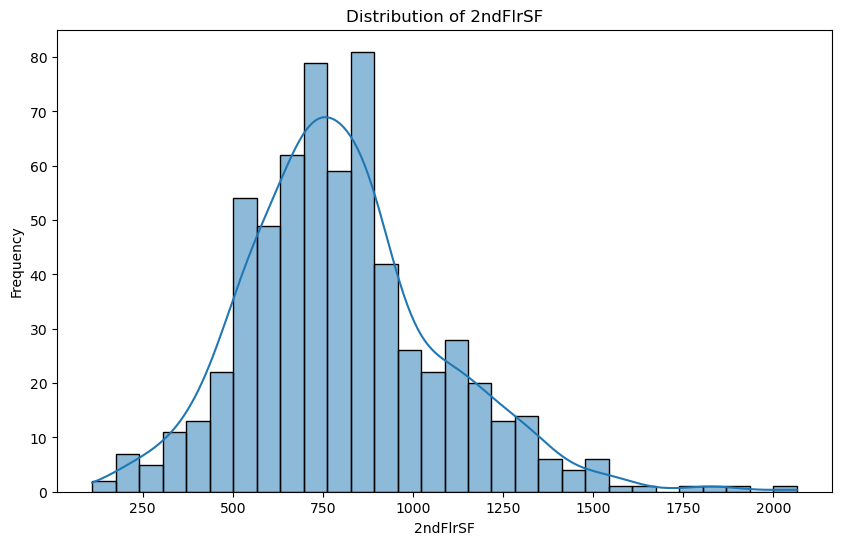

Skewness of 2ndFlrSF: 0.7011031172789908


In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data[train_data['2ndFlrSF']!=0]['2ndFlrSF'], kde=True, bins=30)
plt.title(f'Distribution of 2ndFlrSF')
plt.xlabel('2ndFlrSF')
plt.ylabel('Frequency')
plt.show()

# Calculate and print skewness
feature_skewness = skew(train_data[train_data['2ndFlrSF']!=0]['2ndFlrSF'].dropna())  # dropna() to ignore missing values
print(f'Skewness of 2ndFlrSF: {feature_skewness}')

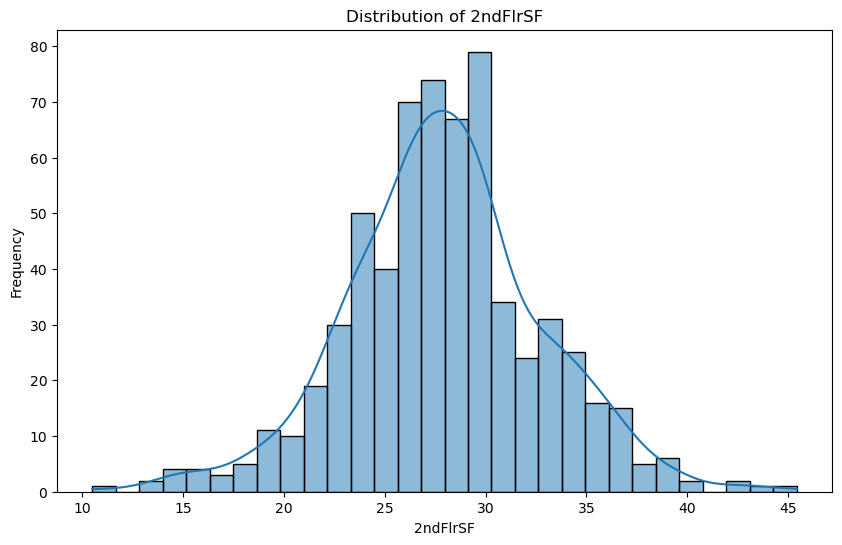

Skewness of 2ndFlrSF: 0.00866543497028905


In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(np.sqrt(train_data[train_data['2ndFlrSF']!=0]['2ndFlrSF']), kde=True, bins=30)
plt.title(f'Distribution of 2ndFlrSF')
plt.xlabel('2ndFlrSF')
plt.ylabel('Frequency')
plt.show()

# Calculate and print skewness
feature_skewness = skew(np.sqrt(train_data[train_data['2ndFlrSF']!=0]['2ndFlrSF']).dropna())  # dropna() to ignore missing values
print(f'Skewness of 2ndFlrSF: {feature_skewness}')

# Generate synthetic data

In [7]:
from sklearn.utils import resample
training_augmented=train_data.copy()
n_augmented_samples = len(train_data)
print(train_data.shape)
X_train_bootstrap, y_train_bootstrap = resample(train_data.loc[:,train_data.columns!='SalePrice'],train_data.loc[:,'SalePrice'], n_samples=n_augmented_samples, replace=True, random_state=42)
synthetic_data=pd.concat([X_train_bootstrap, y_train_bootstrap], axis=1)
synthetic_data['Id']=(synthetic_data['Id'].astype(str) + '_' + (synthetic_data.groupby('Id').cumcount() + 1).astype(str))
#synthetic_data['SalePrice_og']=synthetic_data['SalePrice']
synthetic_data['BsmtFinSF1'] = np.where(synthetic_data['BsmtFinType1'].isin(['NA', 'Unf']),synthetic_data['BsmtFinSF1'],np.power(np.sqrt(synthetic_data['BsmtFinSF1']) + np.random.normal(0, np.sqrt(train_data['BsmtFinSF1']).std() * 0.01, size=len(synthetic_data)), 2))
synthetic_data['BsmtUnfSF']=np.power((np.sqrt(synthetic_data['BsmtUnfSF'])+np.random.normal(0,np.sqrt(train_data['BsmtUnfSF']).std()*0.01,size=len(synthetic_data))),2)
synthetic_data['TotalBsmtSF']=synthetic_data[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF']].sum(axis=1, skipna=True)
synthetic_data['GrLivArea']=np.power((np.sqrt(synthetic_data['GrLivArea'])+np.random.normal(0,np.sqrt(train_data['GrLivArea']).std()*0.01,size=len(synthetic_data))),2)
synthetic_data['1stFlrSF']=np.expm1(np.log1p(synthetic_data['1stFlrSF'])+np.random.normal(0,np.log1p(train_data['1stFlrSF']).std()*0.01,size=len(synthetic_data)))
synthetic_data['MasVnrArea']=np.expm1(np.log1p(synthetic_data['MasVnrArea'])+np.random.normal(0,np.log1p(train_data['MasVnrArea']).std()*0.01,size=len(synthetic_data)))
synthetic_data['LotArea']=np.expm1(np.log1p(synthetic_data['LotArea'])+np.random.normal(0,np.log1p(train_data['LotArea']).std()*0.01,size=len(synthetic_data)))
synthetic_data['LotFrontage']=np.power((np.sqrt(synthetic_data['LotFrontage'])+np.random.normal(0,np.sqrt(train_data['LotFrontage']).std()*0.01,size=len(synthetic_data))),2)
synthetic_data['SalePrice']=synthetic_data['SalePrice']*np.exp(np.random.normal(0,(np.log(train_data['SalePrice']/100000)).std() * 0.01, size=len(synthetic_data)))

synthetic_data.to_csv('synthetic_data.csv',index=False)
synthetic_data

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1126,1127_1,120,RL,52.843214,3712.465560,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,6,2009,WD,Normal,173811.233437
1459,1460_1,20,RL,74.554905,9925.913532,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,6,2008,WD,Normal,147790.480894
860,861_1,50,RL,54.753959,7623.180355,Pave,NA,Reg,Lvl,AllPub,...,0,NA,GdPrv,NA,0,6,2007,WD,Normal,189238.439884
1294,1295_1,20,RL,59.965134,8221.114634,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2006,WD,Normal,115099.839498
1130,1131_1,50,RL,64.633757,7754.859283,Pave,NA,Reg,Lvl,AllPub,...,0,NA,MnPrv,NA,0,12,2009,WD,Normal,135791.296358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,1113_1,20,RL,72.988093,7080.376836,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,7,2006,WD,Normal,130229.576748
1291,1292_3,160,RM,21.092115,1672.698857,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2009,WD,Normal,119191.422207
488,489_2,190,RL,60.070472,10816.624475,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2006,ConLD,Normal,159416.708448
46,47_5,50,RL,47.610919,12967.801427,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,8,2009,WD,Abnorml,238929.991007


In [8]:
train_data_aug = pd.concat([train_data, synthetic_data], axis=0, ignore_index=True)

# Reset the index
train_data_aug = train_data_aug.reset_index(drop=True)
train_data_aug.to_csv('train_data_aug.csv',index=False)
train_data_aug

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450.000000,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500.000000
1,2,20,RL,80.000000,9600.000000,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500.000000
2,3,60,RL,68.000000,11250.000000,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500.000000
3,4,70,RL,60.000000,9550.000000,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000.000000
4,5,60,RL,84.000000,14260.000000,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1113_1,20,RL,72.988093,7080.376836,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,7,2006,WD,Normal,130229.576748
2916,1292_3,160,RM,21.092115,1672.698857,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2009,WD,Normal,119191.422207
2917,489_2,190,RL,60.070472,10816.624475,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2006,ConLD,Normal,159416.708448
2918,47_5,50,RL,47.610919,12967.801427,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,8,2009,WD,Abnorml,238929.991007


# Split data

In [9]:
X_train,X_valid,y_train,y_valid=train_test_split(train_data_aug.loc[:,train_data.columns!='SalesPrice'],train_data_aug.loc[:,train_data.columns=='SalesPrice'],test_size=0.2,random_state=42)
training = X_train.join(y_train)
validation = X_valid.join(y_valid)
X_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2651,640_2,120,RL,53.153431,3959.710181,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,10,2006,New,Partial,264300.340961
1709,151_1,20,RL,120.017753,10315.182120,Pave,NA,Reg,Lvl,AllPub,...,0,NA,MnPrv,NA,0,1,2007,WD,Normal,122179.226645
869,870,60,RL,80.000000,9938.000000,Pave,NA,Reg,Lvl,AllPub,...,0,NA,GdPrv,NA,0,6,2010,WD,Normal,236000.000000
2355,8_1,60,RL,NaN,10298.417533,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,Shed,350,11,2009,WD,Normal,200788.392779
2915,1113_1,20,RL,72.988093,7080.376836,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,7,2006,WD,Normal,130229.576748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,973_1,120,RL,54.829721,7856.585922,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2010,WD,Normal,98870.922800
1095,1096,20,RL,78.000000,9317.000000,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,3,2007,WD,Normal,176432.000000
1130,1131,50,RL,65.000000,7804.000000,Pave,NA,Reg,Lvl,AllPub,...,0,NA,MnPrv,NA,0,12,2009,WD,Normal,135000.000000
1294,1295,20,RL,60.000000,8172.000000,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2006,WD,Normal,115000.000000


In [10]:
training.to_csv('training.csv',index=False)
validation.to_csv('validation.csv',index=False)

In [11]:
nulls = training.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if row[0] > 0:
        print(index, row[0])
    else:
        continue

LotFrontage 428
MasVnrType 11
MasVnrArea 11
Electrical 1
GarageYrBlt 123


In [12]:
nulls = validation.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if row[0] > 0:
        print(index, row[0])
    else:
        continue

LotFrontage 100
MasVnrType 3
MasVnrArea 3
Electrical 1
GarageYrBlt 30


In [13]:
nulls = test_data.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if row[0] > 0:
        print(index, row[0])
    else:
        continue

MSZoning 4
LotFrontage 227
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 16
MasVnrArea 15
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
KitchenQual 1
Functional 2
GarageYrBlt 78
GarageCars 1
GarageArea 1
SaleType 1


In [14]:
def remove_outliers_and_get_skewness(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define the outlier condition
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove the outliers
    filtered_data = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    # Calculate skewness
    column_skewness = skew(filtered_data[column_name], bias=False)

    return column_skewness
def count_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    print(Q1)
    print(Q3)
    IQR = Q3 - Q1

    # Define the outlier condition
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"""Lower bound: {lower_bound}""")
    print(f"""Upper bound: {upper_bound}""")

    # Identify the outliers
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]

    # Return the number of outliers
    return len(outliers)

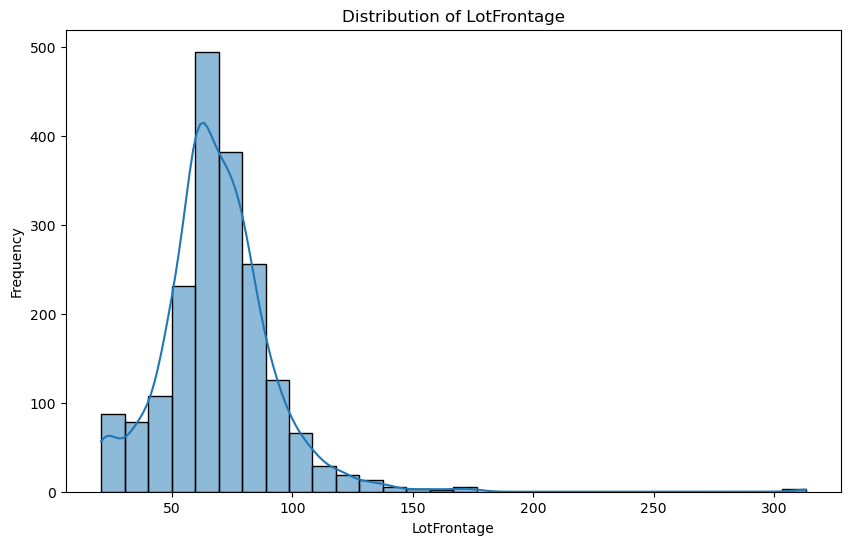

Skewness of LotFrontage before Imputing: 2.117897626731777
Skewness of LotFrontage after removing outliers: 0.17178040453589535
58.12671345035648
80.0
Lower bound: 25.316783625891212
Upper bound: 112.80992982446527
Number of outliers in LotFrontage: 139


In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(training['LotFrontage'], kde=True, bins=30)
plt.title(f'Distribution of LotFrontage')
plt.xlabel('LotFrontage')
plt.ylabel('Frequency')
plt.show()

# Calculate and print skewness
feature_skewness = skew(training['LotFrontage'].dropna())  # dropna() to ignore missing values
print(f'Skewness of LotFrontage before Imputing: {feature_skewness}')
skewness=remove_outliers_and_get_skewness(training,'LotFrontage')
print(f'Skewness of LotFrontage after removing outliers: {skewness}')
num_outliers = count_outliers(training, 'LotFrontage')
print(f'Number of outliers in LotFrontage: {num_outliers}')

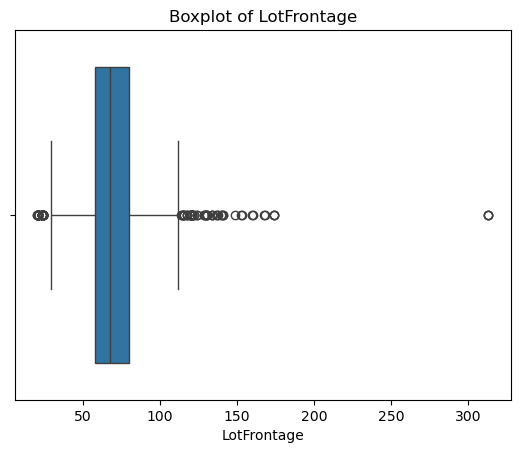

In [16]:
sns.boxplot(data=training, x='LotFrontage')

# Add labels and a title
plt.xlabel('LotFrontage')
plt.title('Boxplot of LotFrontage')

# Show the plot
plt.show()

In [17]:
training['LotFrontage_original']=training['LotFrontage']
training['MasVnrArea_original']=training['MasVnrArea']

In [18]:
from eda_imputation import fill_missing_values
training,validation,test_data=fill_missing_values(training,test_data,validation)

In [19]:
nulls = training.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if (row[0] > 0) and not (index.endswith('_original')):
        print(index, row[0])
    else:
        continue

In [20]:
nulls = validation.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if row[0] > 0:
        print(index, row[0])
    else:
        continue

In [21]:
nulls = test_data.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if row[0] > 0:
        print(index, row[0])
    else:
        continue

In [22]:
training.to_csv('training_filled.csv',index=False)
validation.to_csv('validation_filled.csv',index=False)
test_data.to_csv('test_filled.csv',index=False)

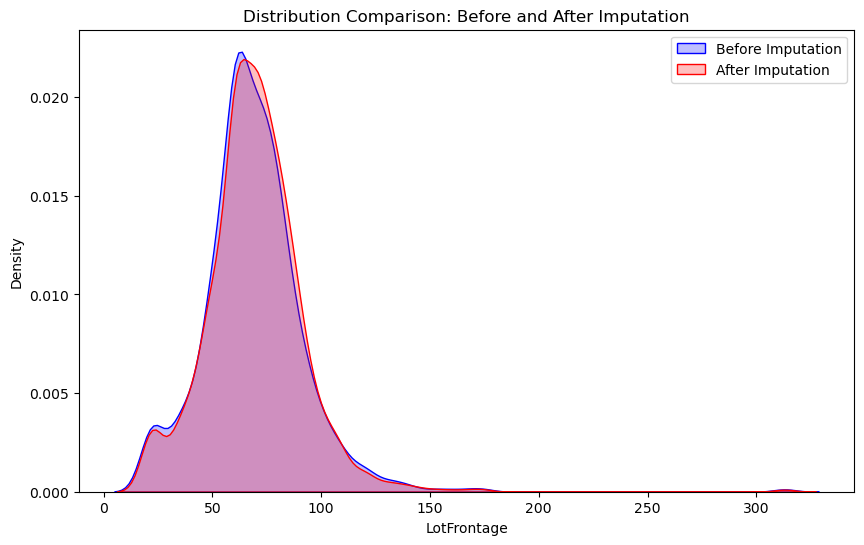

Skewness of LotFrontage after Imputing: 1.8968691249510468
Skewness of LotFrontage after removing outliers: 0.06306285909257003
59.71238329541349
80.04532560042533
Lower bound: 29.212969837895727
Upper bound: 110.54473905794309
Number of outliers in LotFrontage: 155


In [23]:
plt.figure(figsize=(10, 6))

# Plot original data
sns.kdeplot(training['LotFrontage_original'], label='Before Imputation', color='blue', shade=True)

# Plot imputed data
sns.kdeplot(training['LotFrontage'], label='After Imputation', color='red', shade=True)

# Add labels and title
plt.title('Distribution Comparison: Before and After Imputation')
plt.xlabel('LotFrontage')
plt.ylabel('Density')

# Show legend
plt.legend()

# Show plot
plt.show()
feature_skewness = skew(training['LotFrontage'].dropna())  # dropna() to ignore missing values
print(f'Skewness of LotFrontage after Imputing: {feature_skewness}')
skewness=remove_outliers_and_get_skewness(training,'LotFrontage')
print(f'Skewness of LotFrontage after removing outliers: {skewness}')
num_outliers = count_outliers(training, 'LotFrontage')
print(f'Number of outliers in LotFrontage: {num_outliers}')

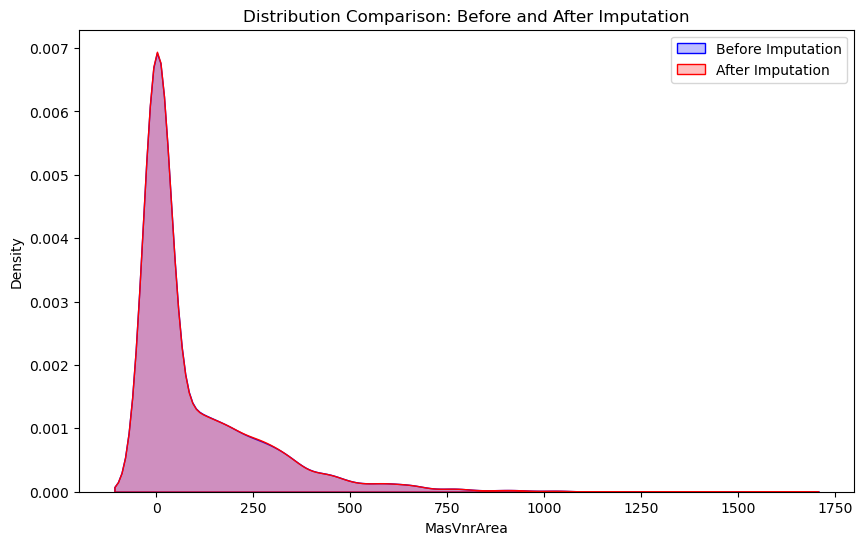

Skewness of LotFrontage after Imputing: 2.595152520068874
Skewness of LotFrontage after removing outliers: 1.4612515702242084
0.0
154.0570196572696
Lower bound: -231.08552948590437
Upper bound: 385.14254914317394
Number of outliers in LotFrontage: 149


In [24]:
plt.figure(figsize=(10, 6))

# Plot original data
sns.kdeplot(training['MasVnrArea_original'], label='Before Imputation', color='blue', shade=True)

# Plot imputed data
sns.kdeplot(training['MasVnrArea'], label='After Imputation', color='red', shade=True)

# Add labels and title
plt.title('Distribution Comparison: Before and After Imputation')
plt.xlabel('MasVnrArea')
plt.ylabel('Density')

# Show legend
plt.legend()

# Show plot
plt.show()
feature_skewness = skew(training['MasVnrArea'].dropna())  # dropna() to ignore missing values
print(f'Skewness of LotFrontage after Imputing: {feature_skewness}')
skewness=remove_outliers_and_get_skewness(training,'MasVnrArea')
print(f'Skewness of LotFrontage after removing outliers: {skewness}')
num_outliers = count_outliers(training, 'MasVnrArea')
print(f'Number of outliers in LotFrontage: {num_outliers}')

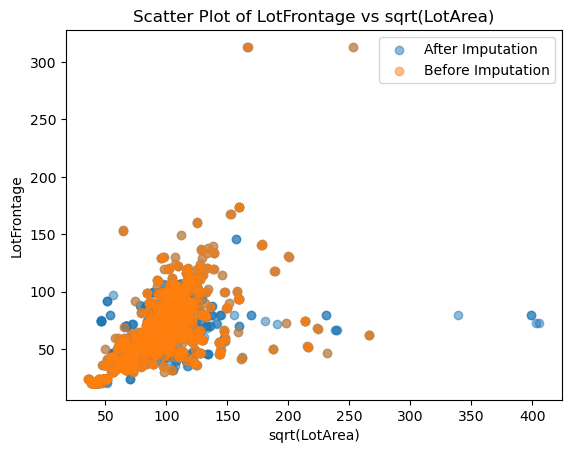

In [25]:
plt.scatter(np.sqrt(training['LotArea']), training['LotFrontage'], label='After Imputation', alpha=0.5)
plt.scatter(np.sqrt(training['LotArea']), training['LotFrontage_original'], label='Before Imputation', alpha=0.5)
plt.xlabel('sqrt(LotArea)')
plt.ylabel('LotFrontage')
plt.legend()
plt.title("Scatter Plot of LotFrontage vs sqrt(LotArea)")
plt.show()

In [26]:
training.drop(columns=[col for col in training.columns if col.endswith('_original')], inplace=True)
training

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,640_2,120,RL,53.153431,3959.710181,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,10,2006,New,Partial,264300.340961
1,151_1,20,RL,120.017753,10315.182120,Pave,NA,Reg,Lvl,AllPub,...,0,NA,MnPrv,NA,0,1,2007,WD,Normal,122179.226645
2,870,60,RL,80.000000,9938.000000,Pave,NA,Reg,Lvl,AllPub,...,0,NA,GdPrv,NA,0,6,2010,WD,Normal,236000.000000
3,8_1,60,RL,94.000000,10298.417533,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,Shed,350,11,2009,WD,Normal,200788.392779
4,1113_1,20,RL,72.988093,7080.376836,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,7,2006,WD,Normal,130229.576748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,973_1,120,RL,54.829721,7856.585922,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2010,WD,Normal,98870.922800
2332,1096,20,RL,78.000000,9317.000000,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,3,2007,WD,Normal,176432.000000
2333,1131,50,RL,65.000000,7804.000000,Pave,NA,Reg,Lvl,AllPub,...,0,NA,MnPrv,NA,0,12,2009,WD,Normal,135000.000000
2334,1295,20,RL,60.000000,8172.000000,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2006,WD,Normal,115000.000000


# Analysis and Transformations to the Response Variable

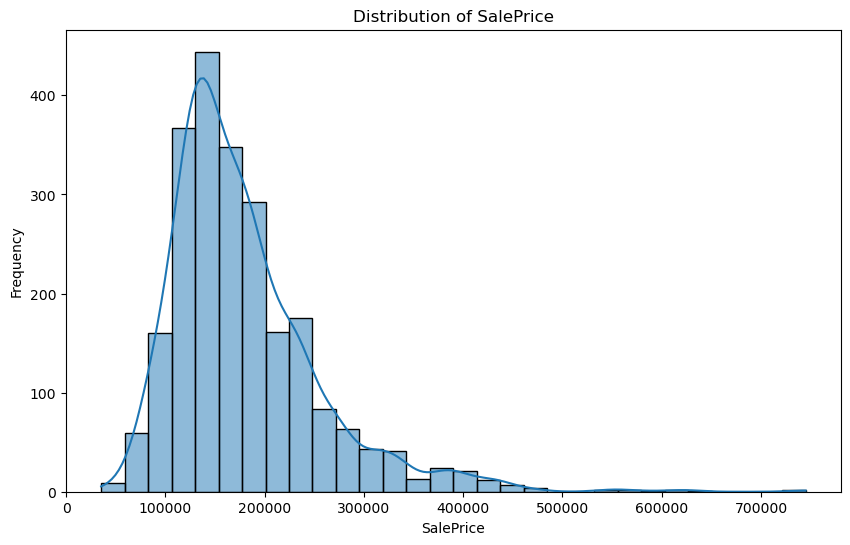

Skewness of SalePrice: 1.8340992750126761
Kurtosis: 6.0040
129630.78618893851
211564.16145490416
Lower bound: 6730.723289990041
Upper bound: 334464.2243538526
Number of outliers in LotFrontage: 110


In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(training['SalePrice'], kde=True, bins=30)
plt.title(f'Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

# Calculate and print skewness
feature_skewness = skew(training['SalePrice'].dropna())  # dropna() to ignore missing values
print(f'Skewness of SalePrice: {feature_skewness}')
print(f"Kurtosis: {training['SalePrice'].kurtosis():.4f}")
num_outliers = count_outliers(training, 'SalePrice')
print(f'Number of outliers in LotFrontage: {num_outliers}')

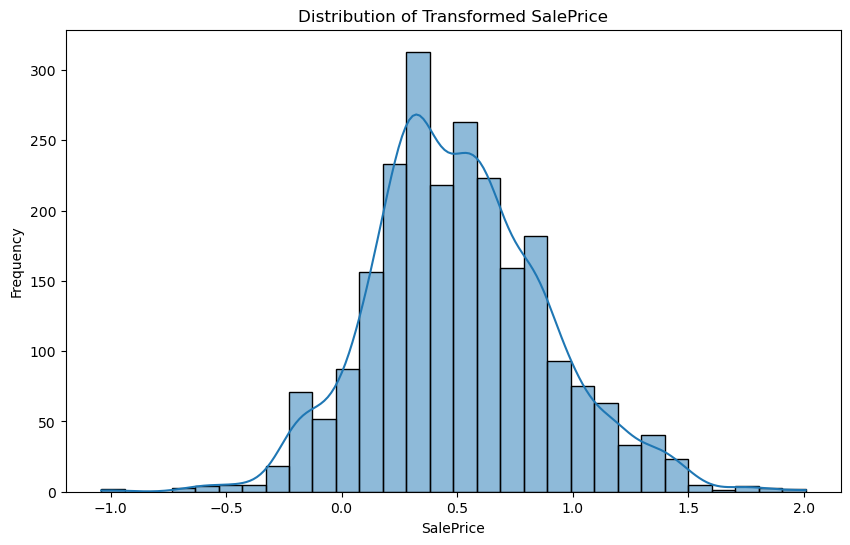

Skewness of SalePrice after transformation: 0.27347720098591727
Kurtosis after transformation: 0.5050
0.2595201135128648
0.7493580886254846
Lower bound: -0.47523684915606484
Upper bound: 1.4841150512944141
Number of outliers in SalePrice: 28


In [28]:
from scipy.stats.mstats import winsorize
training['SalePrice']=np.log(training['SalePrice']/100000)
validation['SalePrice']=np.log(validation['SalePrice']/100000)
plt.figure(figsize=(10, 6))
sns.histplot(training['SalePrice'], kde=True, bins=30)
plt.title(f'Distribution of Transformed SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

# Calculate and print skewness
feature_skewness = skew(training['SalePrice'].dropna())  # dropna() to ignore missing values
print(f'Skewness of SalePrice after transformation: {feature_skewness}')
print(f"Kurtosis after transformation: {training['SalePrice'].kurtosis():.4f}")
num_outliers = count_outliers(training, 'SalePrice')
print(f'Number of outliers in SalePrice: {num_outliers}')

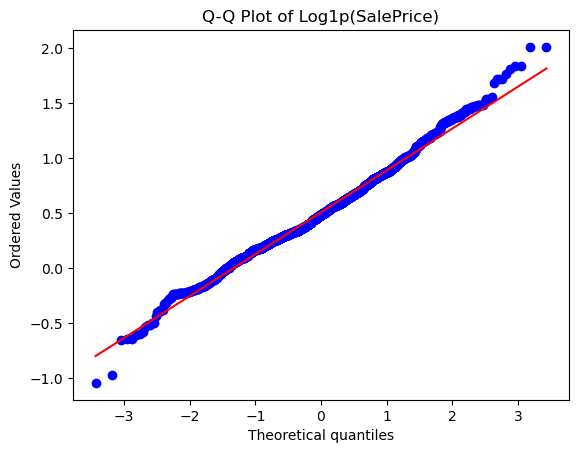

In [29]:
import scipy.stats as stats
# Q-Q Plot
stats.probplot(training["SalePrice"], dist="norm", plot=plt)
plt.title("Q-Q Plot of Log1p(SalePrice)")
plt.show()

# Feature Engineering